In [126]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import random
import cv2
from imutils import paths
import os
from keras.utils import to_categorical
from cnnmodel.similarvggnet import SmallerVGGNet
from keras import optimizers


import shutil

from sklearn.model_selection import train_test_split

%matplotlib inline

In [127]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('Dataset')))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [139]:
EPOCHS = 500
INIT_LR = 1e-4
BS = 32
w=65 #you can change this in a multiple of 2
h=43

# initialize the data and labels
data = []
labels = []

In [140]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio
    key = cv2.waitKey()
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-1].split('_')[0]
    if label == 'Angry':
        label = 0
    elif label == 'Disgusted':
        label = 1
    elif label == 'Afraid':
        label = 2
    elif label == 'Sad':
        label = 3
    elif label == 'Happy':
        label = 4
    else:
        label = 5
    
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [141]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [142]:
trainY = to_categorical(trainY, num_classes=6)
testY = to_categorical(testY, num_classes=6)

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [144]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

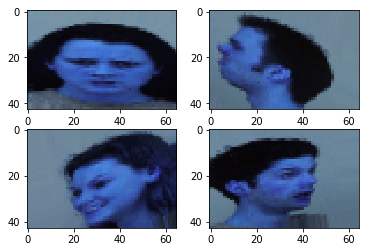

In [145]:
#Checking if a folder already exists. If not create a new one.
if os.path.exists('AugmentedImages'):
    shutil.rmtree('AugmentedImages')
os.mkdir('AugmentedImages')

#Saving and displaying augmented images
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=len(trainX),save_to_dir='AugmentedImages',save_prefix='aug', save_format='png'):
    # create a grid of 2x2 images
    for i in range(0, 4):
        plt.subplot(220 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [93]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

# training_set = train_datagen.flow_from_directory('Dataset/training_set',
#                                                  target_size = (64, 64),
#                                                  batch_size = 32,
#                                                  class_mode = 'binary')

# test_set = test_datagen.flow_from_directory('Dataset/test_set',
#                                             target_size = (64, 64),
#                                             batch_size = 32,
#                                             class_mode = 'binary')

In [94]:
# for X_batch, y_batch in train_datagen.flow_from_directory('Dataset/training_set', batch_size=50, save_format='png'):
#     # create a grid of 2x2 images
#     for i in range(0, 4):
#         plt.subplot(220 + 1 + i)
#         plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#     # show the plot
#     plt.show()
#     break

In [150]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(16, 3, 3, input_shape = (h, w, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(output_dim = 64, activation = 'relu'))
# classifier.add(Dropout(0.2))
classifier.add(Dense(output_dim = 6, activation = 'sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 41, 63, 16)        448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 20, 31, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 18, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 9, 14, 32)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4032)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 390       
Total para

/home/ujjwalgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(43, 65, 3..., activation="relu")`
  """
/home/ujjwalgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/ujjwalgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
/home/ujjwalgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=6)`


In [151]:
H = classifier.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1, callbacks=[es]) 

Epoch 1/500
57/57 [==============================] - 4s 67ms/step - loss: 0.4666 - acc: 0.8277 - val_loss: 0.4442 - val_acc: 0.8333
Epoch 2/500
57/57 [==============================] - 3s 54ms/step - loss: 0.4440 - acc: 0.8333 - val_loss: 0.4542 - val_acc: 0.8333
Epoch 3/500
57/57 [==============================] - 4s 72ms/step - loss: 0.4448 - acc: 0.8333 - val_loss: 0.4409 - val_acc: 0.8333
Epoch 4/500
57/57 [==============================] - 4s 72ms/step - loss: 0.4429 - acc: 0.8333 - val_loss: 0.4397 - val_acc: 0.8333
Epoch 5/500
57/57 [==============================] - 4s 71ms/step - loss: 0.4435 - acc: 0.8333 - val_loss: 0.4391 - val_acc: 0.8333
Epoch 6/500
57/57 [==============================] - 4s 72ms/step - loss: 0.4400 - acc: 0.8333 - val_loss: 0.4394 - val_acc: 0.8333
Epoch 7/500
57/57 [==============================] - 4s 72ms/step - loss: 0.4388 - acc: 0.8333 - val_loss: 0.4355 - val_acc: 0.8333
Epoch 8/500
57/57 [==============================] - 4s 73ms/step - loss: 0.

In [152]:
image = cv2.imread('test1.jpg')
orig = image.copy()
image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio

In [153]:
#image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [154]:
classifier.predict(image)[0]

array([0.00182897, 0.73176956, 0.02889234, 0.16880095, 0.00211728,
       0.07173534], dtype=float32)

In [158]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=w, height=h, depth=3, classes=6)

sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer= sgd, metrics=['accuracy'])


#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#model.compile(loss="binary_crossentropy", optimizer=opt,
#	metrics=["accuracy"])
print(model.summary())

[INFO] compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 43, 65, 32)        896       
_________________________________________________________________
activation_51 (Activation)   (None, 43, 65, 32)        0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 43, 65, 32)        128       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 43, 65, 32)        9248      
_________________________________________________________________
activation_52 (Activation)   (None, 43, 65, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 43, 65, 32)        128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 21, 32, 32)   

In [ ]:
print("[INFO] training network...")
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1, callbacks=[es])

# save the model to disk
print("[INFO] serializing network...")

[INFO] training network...
Epoch 1/500
57/57 [==============================] - 94s 2s/step - loss: 0.7199 - acc: 0.7640 - val_loss: 0.6864 - val_acc: 0.7865
Epoch 2/500
57/57 [==============================] - 89s 2s/step - loss: 0.7077 - acc: 0.7639 - val_loss: 0.5908 - val_acc: 0.7938
Epoch 3/500
57/57 [==============================] - 90s 2s/step - loss: 0.6938 - acc: 0.7674 - val_loss: 0.5019 - val_acc: 0.8200
Epoch 4/500
57/57 [==============================] - 90s 2s/step - loss: 0.7090 - acc: 0.7657 - val_loss: 0.4860 - val_acc: 0.8271
Epoch 5/500
57/57 [==============================] - 90s 2s/step - loss: 0.6729 - acc: 0.7705 - val_loss: 0.4862 - val_acc: 0.8284
Epoch 6/500
57/57 [==============================] - 90s 2s/step - loss: 0.6742 - acc: 0.7681 - val_loss: 0.4744 - val_acc: 0.8301
Epoch 7/500
57/57 [==============================] - 90s 2s/step - loss: 0.6605 - acc: 0.7710 - val_loss: 0.4768 - val_acc: 0.8312
Epoch 8/500
57/57 [==============================] - 90s

Epoch 63/500
57/57 [==============================] - 89s 2s/step - loss: 0.4871 - acc: 0.8194 - val_loss: 0.4492 - val_acc: 0.8328
Epoch 64/500
57/57 [==============================] - 89s 2s/step - loss: 0.4949 - acc: 0.8174 - val_loss: 0.4476 - val_acc: 0.8328
Epoch 65/500
57/57 [==============================] - 89s 2s/step - loss: 0.4856 - acc: 0.8207 - val_loss: 0.4481 - val_acc: 0.8328
Epoch 66/500
57/57 [==============================] - 89s 2s/step - loss: 0.4832 - acc: 0.8192 - val_loss: 0.4461 - val_acc: 0.8328
Epoch 67/500
57/57 [==============================] - 89s 2s/step - loss: 0.4900 - acc: 0.8212 - val_loss: 0.4453 - val_acc: 0.8328
Epoch 68/500
57/57 [==============================] - 89s 2s/step - loss: 0.4781 - acc: 0.8223 - val_loss: 0.4458 - val_acc: 0.8325
Epoch 69/500
57/57 [==============================] - 89s 2s/step - loss: 0.4748 - acc: 0.8258 - val_loss: 0.4455 - val_acc: 0.8328
Epoch 70/500
57/57 [==============================] - 89s 2s/step - loss: 0.

In [ ]:
# save the model to disk
print("[INFO] serializing network...")
model.save('VGGModel.h5')

In [22]:
EPOCHS = len(H.history['loss'])
p = len(test_set) #Number of test sets
pred = []
for a in classifier.predict(test_set):
    if a[1]>a[0]:
        pred.append(1)
    else:
        pred.append(0)
score  = model.evaluate(testX,testY)[1]
z = 1.96 * sqrt( (score * (1 - score)) / p)
print('Accuracy:',round(score,2),'+/-',round(z,2))

AttributeError: 'DirectoryIterator' object has no attribute 'ndim'